In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget


directory   = './data_gitignore/40_310MHz_500Q_moveAnt_18pos_3wallDrive_steelWalls_10_8_23/' #include trailing `/`
#directory   = '../tempData/' #include trailing `/`

freqs_compower = pd.read_csv(directory+'10m Compower AF-Table 1.csv')['Freq., MHz']
AF_compower = pd.read_csv(directory+'10m Compower AF-Table 1.csv')['Manufacturer, ComPower']

s11_measure_freqs = np.linspace(30, 430, 4501)
s11_measure = np.load('./data_gitignore/s11_bicon_calibrateAntannaPort_22pos_benData_10_30_23.npy')

In [2]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import fnmatch
import re

'''
Open and process comsol data files. Save to one large dataframe. 

DF columns:
positionIdx, freq, Ex_near, Ey_n, Ez_n, Enorm_n, Ex_all, Ey_a, Ez_a, Enorm_a, LPV 

Rows:
frequency

shape = (postions * frequency steps) x (11)
size = (1 +(10*4))bytes * nPostions * nFrequencies
18 postions, 1000 frequencies size = 0.73MB

Also save text file with look up table of 
postionIdx, X, Y, Z, Alpha, Beta, Gamma
'''



#get list of files in directory
files = [f for f in listdir(directory) if isfile(join(directory, f))]
assert files != [], f"empty list in {directory}"

#generate list of file names that match pattern strings
#assumes order of "near, all, lpv"!!!!
pattern_strs    = ['.*allE.*Near.*','.*allE.*all.*', '.*LPV.*', '.*s11_18pos*.*'] 
#pattern_strs    = ['.*allE.*Near.*','.*allE.*all.*'] 
fileNames       = []
for pattern_str in pattern_strs:
    pattern     = re.compile(pattern_str, re.IGNORECASE)
    fileName    = [s for s in files if pattern.match(s)]
    try: 
        assert len(fileName) == 1
    except:
        print(f"No files or multple files match ' {pattern_str}. Check directory {directory}\n")
        continue
    fileNames.append(fileName[0])
assert len(fileNames) != 0, f'no files in {directory} match'

print(f'{len(fileNames)} File names will be used to create DF:')
for file in fileNames: print(file)  

dfOut = pd.DataFrame()

#perform fuckary to fix comsol's stupid text file output. 
#modify 4th row of text (column names) to have white space delimiter and split on whitespace
for fileIdx, fileName in enumerate(fileNames):
    with open(directory + fileName, 'r') as f:
        data = f.readlines()
    data[4] = data[4].replace('%','')
    data[4] = data[4].replace(' (cm)','(cm)')
    data[4] = data[4].replace(' (MHz)','(MHz)')
    data[4] = data[4].replace('abs(emw.Ex) (V/m), Point: (', ' Ex_atPoint(') #header must start with 'E<i>' 
    data[4] = data[4].replace('abs(emw.Ey) (V/m), Point: (', ' Ey_atPoint(') #on these 3 lines.
    data[4] = data[4].replace('abs(emw.Ez) (V/m), Point: (', ' Ez_atPoint(')
    data[4] = data[4].replace('abs(emw.normE) (V/m), Point: (', ' Enorm_atPoint(')
    data[4] = data[4].replace(', ',',')
    data[4] = data[4].replace('(V)','')
    header = data[4].split()
    print()
    print(fileName)
    #print(header)
    # read the file and skip the first 5 rows, get column names from header defined above
    df = pd.read_csv(directory + fileName, delim_whitespace=True, skiprows=5, header=None)
    df.columns = header

    #overwrite position and frequency columns to make life easy
    positionCol = df[[col for col in df if col.startswith('positionIdx')]]
    #print(positionCol)
    dfOut['positionIdx'] = positionCol.astype(np.int16)
    freqCol = df[[col for col in df if col.startswith('freq')]]
    dfOut['freq(MHz)'] = freqCol.astype(np.float32)

    ############## Data extraction. Modify here to add new files ##############

    #extract field from non LPV files
    #if ('LPV' not in fileName) and ('lpv' not in fileName) and ('Lpv' not in fileName):
    if ('allE_' in fileName):
        print(fileName)
        fieldCompStrs   = ['Ex', 'Ey', 'Ez', 'Enorm']
        if ('near' in fileName) or ('Near' in fileName):
            fieldLoc = '_near'
        else:
            fieldLoc = '_all'
        for fieldCompStr in fieldCompStrs:
            filter_col = [col for col in df if col.startswith(fieldCompStr)]
            try:
                assert filter_col != []
            except:
                print(f'no data for {fieldCompStr} in {fileName}')
            dfOut[fieldCompStr+fieldLoc] = df[filter_col].mean(axis=1).astype(np.float32)
    #else extract LPV from LPV file
    if ('LPV' in fileName) or ('lpv' in fileName) or ('Lpv' in fileName):
        filter_col = [col for col in df if col.startswith('abs(emw.Vport')]
        dfOut['LPV'] = df[filter_col].astype(np.float32)
    if ('s11' in fileName):
        filter_col = [col for col in df if col.startswith('S11(1)')]
        dfOut['s11'] = df[filter_col].astype(np.float32)
def dBs11ToLin(dB):
    return 10**(dB/20)
dfOut['s11'] = dfOut['s11'].transform(dBs11ToLin)
dfOut.head()
dfOut.to_pickle(directory+'dataDf.npy')

4 File names will be used to create DF:
allE_NearField.txt
allE_all_64pos.txt
LPV.txt
s11_18pos_10_12_23.txt

allE_NearField.txt
allE_NearField.txt

allE_all_64pos.txt
allE_all_64pos.txt

LPV.txt

s11_18pos_10_12_23.txt


In [3]:
df = np.load(directory + 'dataDf.npy', allow_pickle=True)
df.head()

,positionIdx,freq(MHz),Ex_near,Ey_near,Ez_near,Enorm_near,Ex_all,Ey_all,Ez_all,Enorm_all,LPV,s11
0,0,40.000000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
1,0,40.080002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
2,0,40.160000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
3,0,40.240002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
4,0,40.320999,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999968


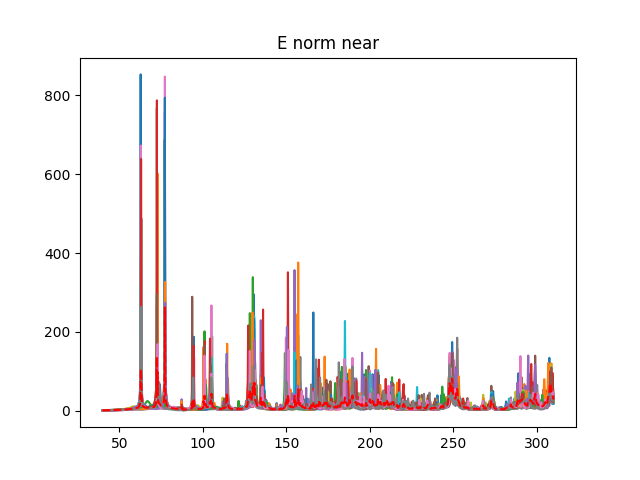

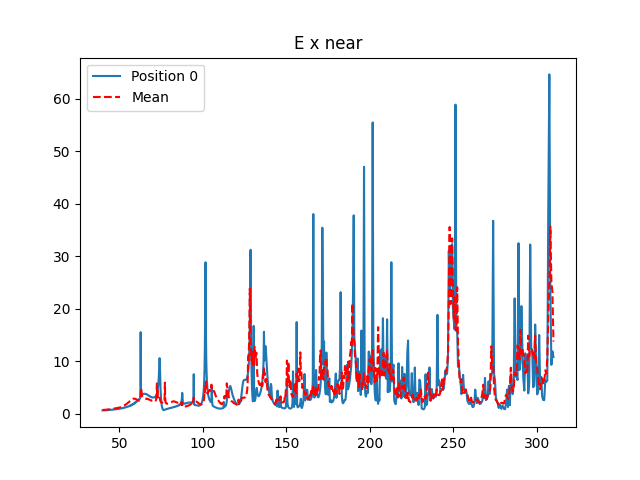

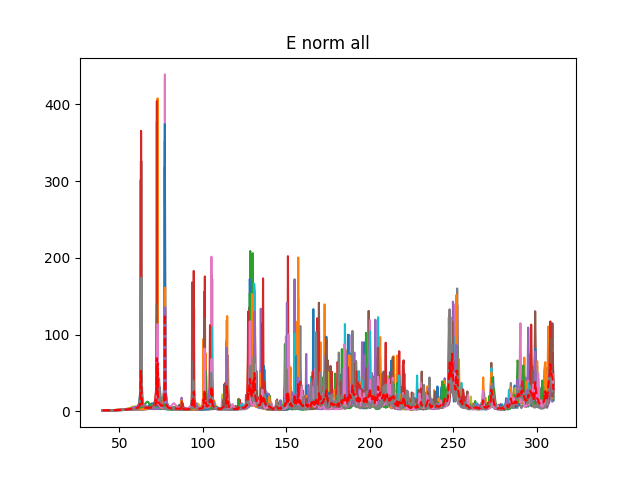

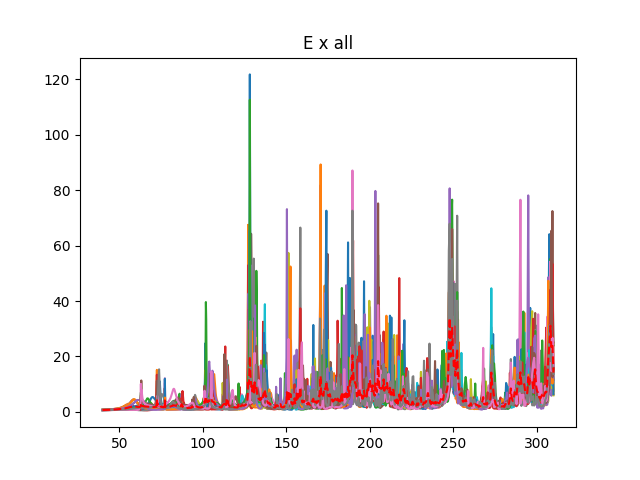

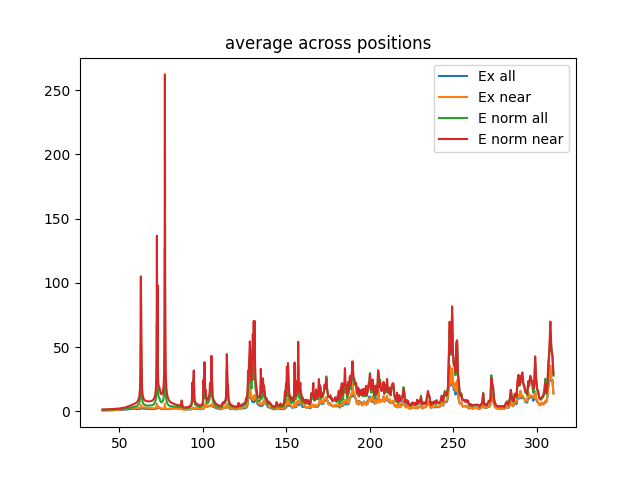

In [4]:
#plot E field stuff

plt.close('all')

plt.figure()
plt.title('E norm near')
for name, group in df.groupby('positionIdx'):
    plt.plot(group['freq(MHz)'], group['Enorm_near'], label=f'Position {name}')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Enorm_near'], 'r--', label = 'Mean')

plt.figure()
plt.title('E x near')
for name, group in df.groupby('positionIdx'):
    plt.plot(group['freq(MHz)'], group['Ex_near'], label=f'Position {name}')
    break
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Ex_near'], 'r--', label = 'Mean')
plt.legend()

plt.figure()
plt.title('E norm all')
for name, group in df.groupby('positionIdx'):
    plt.plot(group['freq(MHz)'], group['Enorm_all'], label=f'Position {name}')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Enorm_all'], 'r--', label = 'Mean')

plt.figure()
plt.title('E x all')
for name, group in df.groupby('positionIdx'):
    plt.plot(group['freq(MHz)'], group['Ex_all'], label=f'Position {name}')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Ex_all'], 'r--', label = 'Mean')

plt.figure()
plt.title('average across positions')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Ex_all'], label = 'Ex all')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Ex_near'], label = 'Ex near')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Enorm_all'], label = 'E norm all')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['Enorm_near'], label = 'E norm near')
plt.legend()

Text(0, 0.5, 's11 (lin)')

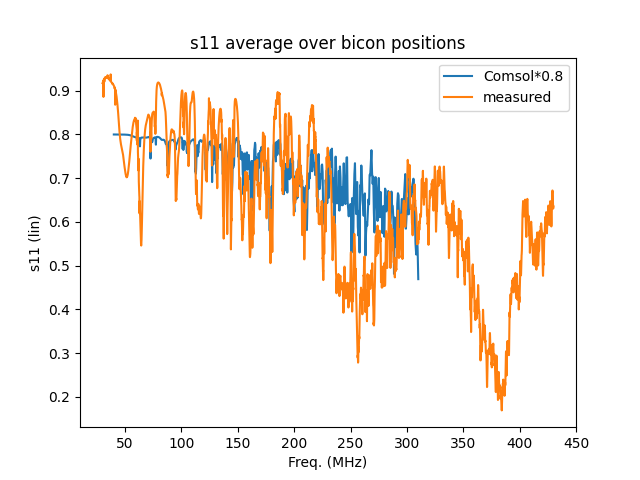

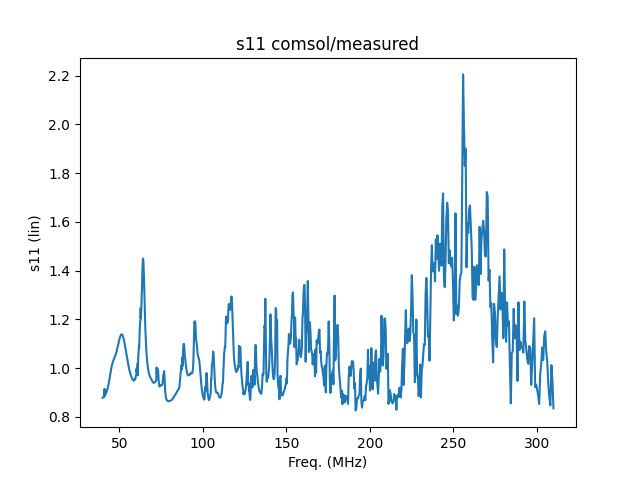

In [5]:

plt.close('all')

plt.figure()
plt.title('s11 average over bicon positions')
#for name, group in df.groupby('positionIdx'):
#    plt.plot(group['freq(MHz)'], group['s11'], label=f'Position {name}')
plt.plot(group['freq(MHz)'], (df.groupby('freq(MHz)').mean()['s11'])*0.8, label = 'Comsol*0.8')
plt.plot(s11_measure_freqs, s11_measure, label = "measured")
plt.xlabel('Freq. (MHz)')
plt.ylabel('s11 (lin)')
plt.legend()

s11_measure_interp =  np.interp(group['freq(MHz)'],s11_measure_freqs, s11_measure)


plt.figure()
plt.title('s11 comsol/measured')
plt.plot(group['freq(MHz)'], (df.groupby('freq(MHz)').mean()['s11']/s11_measure_interp) *.8, label = 'Mean')
plt.xlabel('Freq. (MHz)')
plt.ylabel('s11 (lin)')


af dB: -0.8340812343528681
Lin pow mean and std = 1.1008, 0.6696980595588684


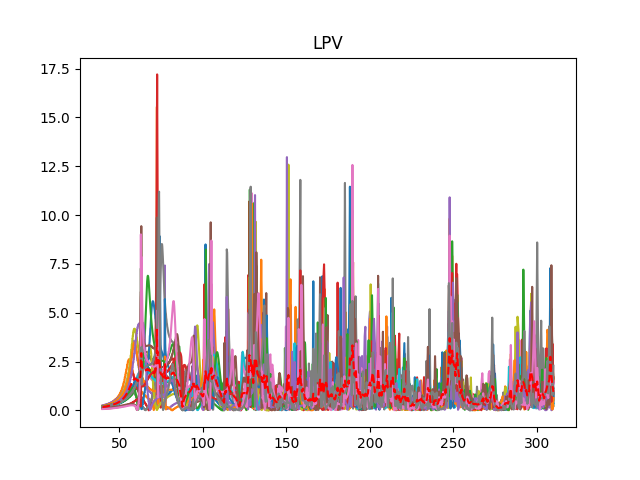

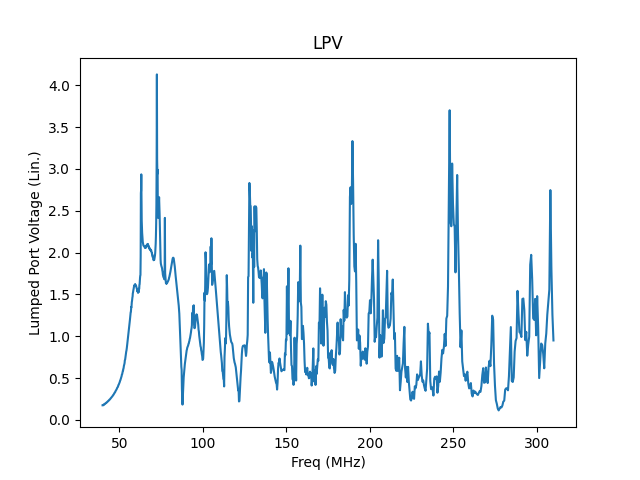

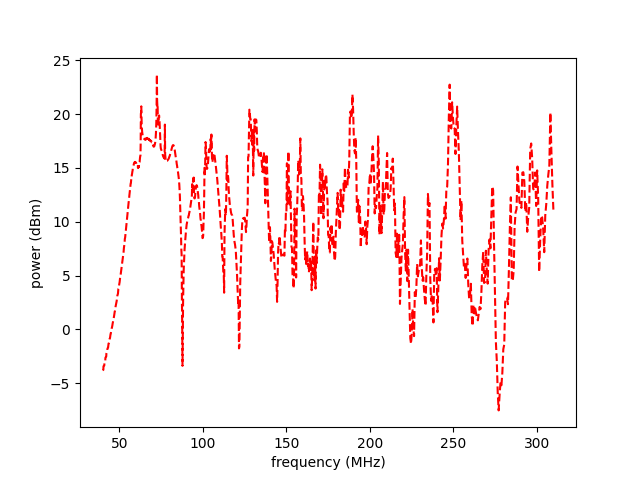

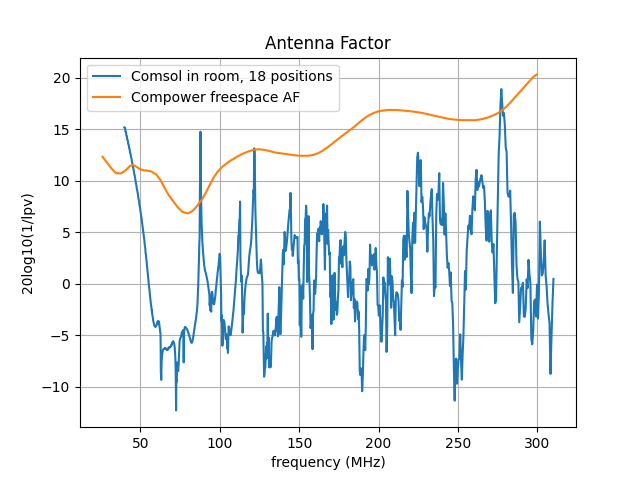

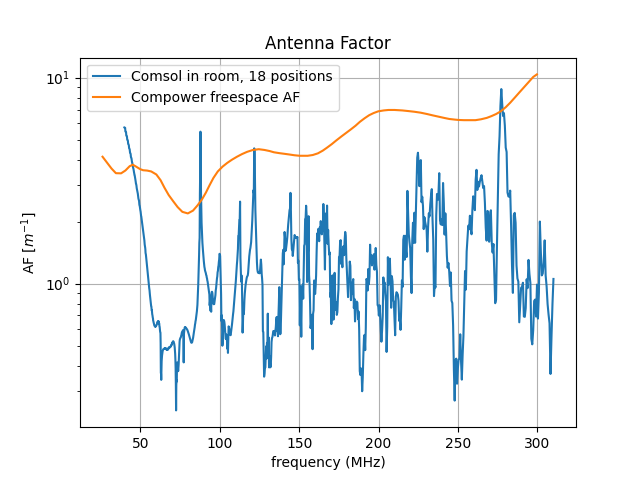

In [15]:
#plt LPV stuff

plt.close('all')

plt.figure()
plt.title('LPV')
for name, group in df.groupby('positionIdx'):
    plt.plot(group['freq(MHz)'], group['LPV'], label=f'Position {name}')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['LPV'], 'r--', label = 'Mean')

plt.figure()
plt.title('LPV')
plt.plot(group['freq(MHz)'], df.groupby('freq(MHz)').mean()['LPV'])
plt.xlabel('Freq (MHz)')
plt.ylabel('Lumped Port Voltage (Lin.)')


#power
plt.figure()
plt.plot(group['freq(MHz)'], 10*np.log10((df.groupby('freq(MHz)').mean()['LPV'])**2/73 * 1000), 'r--', label = 'Mean')
plt.xlabel('frequency (MHz)')
plt.ylabel('power (dBm)')

#AF lpv dB
plt.figure()
plt.title("Antenna Factor")
plt.plot(group['freq(MHz)'], 20*np.log10(1/df.groupby('freq(MHz)').mean()['LPV']), label = 'Comsol in room, 18 positions')
plt.plot(freqs_compower, AF_compower, label = 'Compower freespace AF')
plt.xlabel('frequency (MHz)')
plt.ylabel('20log10(1/lpv)')
plt.legend()
plt.grid(True)

#AF lpv log
plt.figure()
plt.title("Antenna Factor")
plt.plot(group['freq(MHz)'], (1/df.groupby('freq(MHz)').mean()['LPV']), label = 'Comsol in room, 18 positions')
plt.plot(freqs_compower, 10**(AF_compower/20), label = 'Compower freespace AF')
plt.xlabel('frequency (MHz)')
plt.ylabel(f'AF [$m^{{-1}}$]')
plt.semilogy()
plt.legend()
plt.grid(True)

afdB = 20*np.log10(1/(np.mean(df.groupby('freq(MHz)').mean()['LPV'])))
print(f'af dB: {afdB}')

meanPow = np.mean(df.groupby('freq(MHz)').mean()['LPV'].mean())
stdPow = np.std(df.groupby('freq(MHz)').mean()['LPV'])

print(f'Lin pow mean and std = {np.round(meanPow,4)}, {stdPow}')

room area: 55.80519999999999 m^2
4.109362960409999e-07
1817.8723718519125
A_e 0.01259976632810838 m^2
P_r theory: 0.06075535039697146 W
P_r theory: 17.835845299339237 dBm
LPV theory 1.7429192522456607


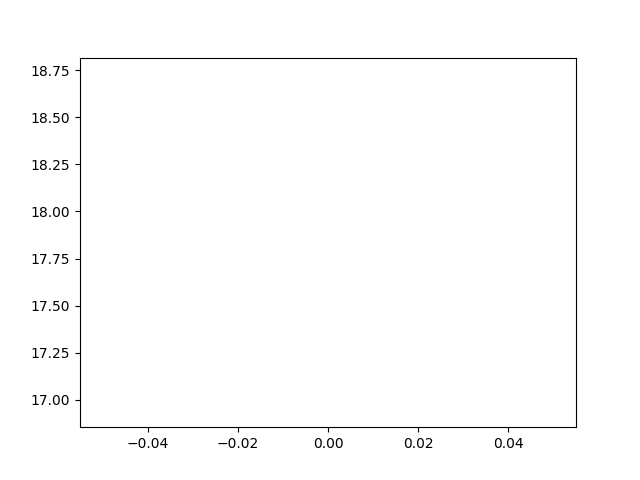

In [16]:
#aperature

#antenna parameters
p = 1/3
m = 1/2
e = .95

Z_fs = 377 #ohms

freq = 300e6

#Box sides
length = 3.07
width = 2.46
height = 3.68
volume = length * width * height
area = 2 * length * width + 2 * width * height + 2 * height * length
print(f'room area: {area} m^2')

def skin_depth(freq, mu_r, sigma):
 return 1/(np.sqrt(np.pi * freq * mu_r * (4*np.pi*1e-7) * sigma))

print(skin_depth(300e6, 1000, 5e6))
Q = 3 * volume / (2 * 1000 * skin_depth(freq, 1000, 5e6) * area)
print(Q)

#Theory <A_e>
A_e = (3e8/freq)**2/(4*np.pi) * p *  m * e
print(f'A_e {A_e} m^2')
#theory received power
#P_r = 

P_r_theory = (Q * 1) /Z_fs * 1**2/(4*np.pi) * p *  m * e
print(f'P_r theory: {P_r_theory} W')
print(f'P_r theory: {10*np.log10(P_r_theory*1000)} dBm')
plt.close('all')
plt.figure()
plt.plot(10*np.log10(P_r_theory*1000))

print(f'LPV theory {np.sqrt(P_r_theory*50)}')


KeyError: 'Freq'

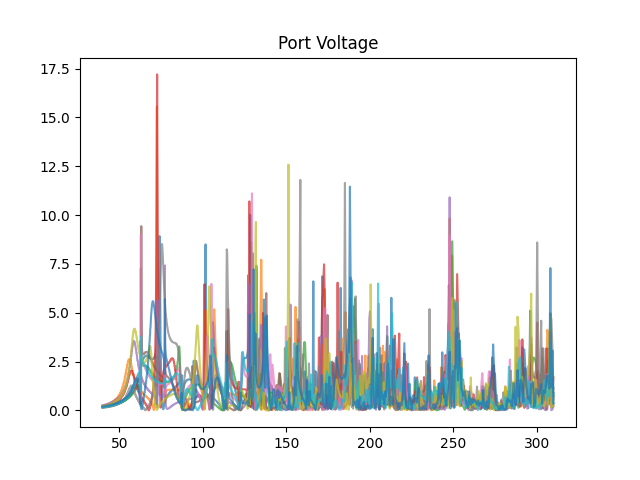

In [17]:
plt.close('all')
%matplotlib widget
nAntPositions = 11
freqs = group['freq(MHz)']

plt.figure()
plt.title('Port Voltage')
for i in range(nAntPositions):
    plt.plot(freqs, df[df['positionIdx']==i]['LPV'], alpha = .7)
plt.plot(freqs, df.groupby('Freq').mean()['LPV'],'r--',label = 'Mean')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Port Voltage (Volts)')
plt.legend()

plt.figure()
plt.title('AF (E = 1V/m)')
for i in range(nAntPositions):
    plt.plot(freqs, 20*np.log10(1/df[df['Position']==i]['LPV']), alpha = .7, label = '%i'%i)
plt.plot(freqs, 20*np.log10(1/df.groupby('Freq').mean()['LPV']),'r--',label = 'Mean')
plt.xlabel('Frequency (MHz)')
plt.ylabel('20log10(1/V) ')
plt.legend()

plt.figure()
plt.title('AF (E = 1V/m)')
for i in range(nAntPositions):
    plt.plot(freqs, 20*np.log10(df[df['Position']==i]['E_near_Norm']/df[df['Position']==i]['LPV']), alpha = .7, label = '%i'%i)
plt.plot(freqs, 20*np.log10(1/df.groupby('Freq').mean()['LPV']),'r--',label = 'Mean')
plt.xlabel('Frequency (MHz)')
plt.ylabel('20log10(1/V) ')
plt.legend()

plt.figure()
plt.title('E Averaged Around Antenna')
for i in range(nAntPositions):
    plt.plot(freqs, df[df['Position']==i]['E_near_Norm'], alpha = .7)
plt.plot(freqs, df.groupby('Freq').mean()['E_near_Norm'],'r--',label = 'Mean')
plt.xlabel('Frequency (MHz)')
plt.ylabel('E(V/m)')
plt.legend()

plt.figure()
plt.title('E Averaged Over Room')
for i in range(nAntPositions):
    plt.plot(freqs, df[df['Position']==i]['E_all_Norm'], alpha = .7)
plt.plot(freqs, df.groupby('Freq').mean()['E_all_Norm'],'r--',label = 'Mean')
plt.xlabel('Frequency (MHz)')
plt.ylabel('E(V/m)')
plt.legend()

In [ ]:
#compare awe to non awe
nFreqs = 80
AWE_df, freqs, nAntPositions = makeDf('1pos_98_106MHz_80freqpts_cons5.9e6_perm1000_realDimentions_AWE', nFreqs=nFreqs)
nonAWE_df, freqs, nAntPositions = makeDf('1pos_98_106MHz_80freqpts_cons5.9e6_perm1000_realDimentions_nonAWE', nFreqs=nFreqs)

plt.figure()
plt.title('Port Voltage')
plt.scatter(freqs, AWE_df.groupby('Freq').mean()['LPV'],label = 'AWE')
plt.plot(freqs, AWE_df.groupby('Freq').mean()['LPV'],label = 'AWE')
plt.scatter(freqs, nonAWE_df.groupby('Freq').mean()['LPV'],label = 'Non AWE')
plt.plot(freqs, nonAWE_df.groupby('Freq').mean()['LPV'],label = 'Non AWE')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Port Voltage (Volts)')
plt.legend()



In [ ]:
#generate names
avgList = ['near', 'all']
vecList = ['X', 'Y', 'Z', 'Norm']
for avgType in avgList:
    for vecType in vecList:
        print("'E_"+avgType+"_"+vecType+"',")
        #print("df['E_"+avgType+"_"+vecType+"'] = E_"+avgType.lower()+"_"+vecType.lower()) 

In [ ]:

x = 3.0697 #comsol width, real E(ast)
y = 2.4566 #comsel depth, real V(ert)
z = 3.6840 #comsol height, real N(orth)
 
def comsolToReal(xIn = -x/2, yIn = -y/2 , zIn = -z/2):
    print('North = ', z/2 - zIn)
    print('East = ', xIn + x/2)
    print('Vertical = ', yIn + y/2)


def realToComsol(nIn = -z/2, eIn = x/2, vIn = y/2):
    print('X =', eIn - x/2)
    print('Y =', vIn - y/2)
    print('Z =', nIn + z/2)

realToComsol()


In [ ]:
randList = [np.random.randint(90) for x in range(18)]
randList

In [ ]:
bigdf, freqs, nAntPositions = makeDf('18pos_50_300MHz_500freqpts_cons5.9e6_perm1000_realDimentions_nonAWE', 500)
bigdfAwe, freqs, nAntPositions = makeDf('18pos_50_300MHz_500freqpts_cons5.9e6_perm1000_realDimentions_AWE', 500)

plt.close('all')
%matplotlib widget

plt.figure()
plt.title('Port Voltage')
if 1:
    for i in range(nAntPositions):
        plt.plot(freqs, (bigdf[bigdf['Position']==i]['LPV']), alpha = .7)

#plt.plot(freqs, 20*np.log10(bigdf.groupby('Freq').median()['LPV']),'r',label = 'non AWE')
#plt.plot(freqs, 20*np.log10(bigdf.groupby('Freq').mean()['LPV']),label = 'mean')
#plt.plot(freqs, 20*np.log10(bigdfAwe.groupby('Freq').mean()['LPV']) ,label = 'AWE', alpha = .6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('20 log10(Port Voltage)')
plt.legend()

In [ ]:
df, freqs, nAntPositions = makeDf('18pos_118_131MHz_250freqpts_cons5.9e6_perm1000_realDimentions_nonAWE', 250)

plt.close('all')
%matplotlib widget

plt.figure()
plt.title('Port Voltage')
if 1:
    for i in range(nAntPositions):
        plt.plot(freqs, 20*np.log10(df[df['Position']==i]['LPV']),
        alpha = .7,
        label = '%i'%i)

plt.plot(freqs, 20*np.log10(df.groupby('Freq').mean()['LPV']),'r',label = 'non AWE')

if 1:
    posNum = 6
    plt.plot(freqs, 20*np.log10(df[df['Position']==posNum]['LPV']),
        'r--',
        alpha = 1,
        label = '%i'%posNum)
plt.xlabel('Frequency (MHz)')
plt.ylabel('20 log10(Port Voltage)')
plt.legend()

In [ ]:
df.keys()

In [ ]:
df